In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import pandas as pd

import pickle

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## CIFAR-100

MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 298

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [3]:
# ## CIFAR-10

# MODEL_FOLDER = 'cifar10/models'
# LIKELIHOOD = 'softmax'
# EPOCH = "049"

# logits, targets, ARGS = get_logits_targets('cifar10', MODEL_FOLDER, LIKELIHOOD, EPOCH)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [24]:
# ## ImageNet

# with open(f'output/ImageNet.p', 'rb') as f:
#     data = pickle.load(f)
# logits, targets, ARGS = data

In [5]:
L = len(logits)
N = len(targets)

## 1 Ablations

In [6]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [7]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [8]:
# logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
logits_poe = logits.cumsum(dim=0)
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [9]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [10]:
probs_ovr = ovr_likelihood(logits)
probs_moe_ovr = probs_ovr.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_moe_ovr = {i: torch.argmax(probs_moe_ovr, dim=2)[i, :] for i in range(L)}
acc_moe_ovr = [(targets == preds_moe_ovr[i]).sum() / len(targets) for i in range(L)]

In [11]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

In [12]:
probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
preds_ovr_break_ties = {i: torch.argmax(probs_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_ovr_break_ties = [(targets == preds_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [13]:
probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
probs_moe_ovr_break_ties = probs_ovr_break_ties.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_moe_ovr_break_ties = {i: torch.argmax(probs_moe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_moe_ovr_break_ties = [(targets == preds_moe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [14]:
T = 1.
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [15]:
probs_poe_ovr_break_ties_softmax = torch.tensor(f_probs_ovr_poe_logits_softmax(logits, L=L))
preds_poe_ovr_break_ties_softmax = {i: torch.argmax(probs_poe_ovr_break_ties_softmax, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_softmax = [(targets == preds_poe_ovr_break_ties_softmax[i]).sum() / len(targets) for i in range(L)]

In [16]:
THRESHOLDS_MONOTONE = [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]

df_accuracy = pd.DataFrame(columns=[l for l in range(1, L+1)])
df_monotone = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
df_monotone_rel = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
for likelihood, ensemble_type, _acc, _probs, _preds in [("softmax", "/", acc, probs, preds),
                                                        ("softmax", "MoE", acc_de, probs_de, preds_de),
                                                        ("softmax", "PoE", acc_poe, probs_poe, preds_poe),
                                                        ("hard OvR", "/", acc_ovr, probs_ovr, preds_ovr),
                                                        ("hard OvR", "MoE", acc_moe_ovr, probs_moe_ovr, preds_moe_ovr),
                                                        ("hard OvR", "PoE", acc_poe_ovr, probs_poe_ovr, preds_poe_ovr),
                                                        ("tie-breaking OvR", "/", acc_ovr_break_ties, probs_ovr_break_ties, preds_ovr_break_ties),
                                                        ("tie-breaking OvR", "MoE", acc_moe_ovr_break_ties, probs_moe_ovr_break_ties, preds_moe_ovr_break_ties),
                                                        ("tie-breaking OvR", "PoE", acc_poe_ovr_break_ties, probs_poe_ovr_break_ties, preds_poe_ovr_break_ties),
                                                        ("softmax OvR", "PoE", acc_poe_ovr_break_ties_softmax, probs_poe_ovr_break_ties_softmax, preds_poe_ovr_break_ties_softmax)
                                                        ]:
    if _acc:
        df_accuracy.loc[f'{likelihood}-{ensemble_type}', :] = [round(float(x), 4) * 100 for x in _acc]
        df_monotone.loc[f'{likelihood}-{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing(_preds, _probs, L, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]
        df_monotone_rel.loc[f'{likelihood}-{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing_relative(_preds, _probs, L, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]

In [17]:
df_accuracy

,1,2,3,4,5,6,7
softmax-/,65.32,68.3,70.78,72.31,72.54,72.81,72.74
softmax-MoE,65.32,69.77,72.91,74.3,75.35,75.79,75.91
softmax-PoE,65.32,70.24,73.56,74.56,75.49,75.99,76.06
hard OvR-/,2.12,2.1,2.39,2.44,2.24,2.24,2.16
hard OvR-MoE,2.12,2.87,3.67,4.19,4.62,4.92,5.13
hard OvR-PoE,2.12,2.87,3.67,4.19,4.62,4.92,5.13
tie-breaking OvR-/,65.32,68.3,70.78,72.31,72.54,72.81,72.74
tie-breaking OvR-MoE,65.32,70.26,73.57,74.5,75.53,75.98,76.03
tie-breaking OvR-PoE,65.32,70.17,73.47,74.88,75.41,75.77,75.71
softmax OvR-PoE,65.32,70.24,73.56,74.56,75.49,75.99,76.06


In [37]:
for row in df_accuracy[[1, 2, L]].iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

softmax-/
83.3 & 85.75 & 86.92
softmax-MoE
83.3 & 86.1 & 88.5
softmax-PoE
83.3 & 86.19 & 88.5
hard OvR-/
18.45 & 19.93 & 21.69
hard OvR-MoE
18.45 & 22.27 & 29.93
hard OvR-PoE
18.45 & 22.27 & 29.92
tie-breaking OvR-/
83.3 & 85.75 & 86.92
tie-breaking OvR-MoE
83.3 & 86.11999999999999 & 88.55
tie-breaking OvR-PoE
83.3 & 86.27 & 88.38000000000001


In [18]:
df_monotone

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax-/,86.76,67.36,56.36,50.38,41.6,38.05,32.95,23.19
softmax-MoE,68.29,54.35,41.35,30.25,17.17,12.61,7.79,1.67
softmax-PoE,29.75,23.2,18.03,14.6,10.3,8.87,6.45,3.35
hard OvR-/,92.4,41.46,0.0,0.0,0.0,0.0,0.0,0.0
hard OvR-MoE,84.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hard OvR-PoE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR-/,96.51,63.97,0.26,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR-MoE,64.7,7.54,0.0,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR-PoE,0.45,0.16,0.01,0.0,0.0,0.0,0.0,0.0
softmax OvR-PoE,64.42,44.36,30.95,22.43,11.91,8.81,5.07,1.35


In [19]:
for row in df_monotone[[-0.01, -0.1, -0.25]].iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

softmax-/
67.36 & 50.38 & 38.05
softmax-MoE
54.35 & 30.25 & 12.61
softmax-PoE
23.2 & 14.6 & 8.87
hard OvR-/
41.46 & 0.0 & 0.0
hard OvR-MoE
0.0 & 0.0 & 0.0
hard OvR-PoE
0.0 & 0.0 & 0.0
tie-breaking OvR-/
63.97 & 0.0 & 0.0
tie-breaking OvR-MoE
7.54 & 0.0 & 0.0
tie-breaking OvR-PoE
0.16 & 0.0 & 0.0
softmax OvR-PoE
44.36 & 22.43 & 8.81


In [19]:
df_monotone_rel

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax-/,86.59,68.7,59.71,55.16,50.15,48.13,45.08,39.29
softmax-MoE,67.82,55.4,47.31,41.6,31.14,26.38,18.89,4.72
softmax-PoE,64.18,45.13,34.85,28.44,20.23,16.73,12.51,5.78
hard OvR-/,92.47,92.47,85.89,69.33,42.71,40.72,40.51,40.51
hard OvR-MoE,92.5,72.73,16.7,2.1,0.01,0.0,0.0,0.0
hard OvR-PoE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tie-breaking OvR-/,96.72,95.0,84.91,64.69,28.32,17.22,7.89,1.43
tie-breaking OvR-MoE,66.43,55.73,27.31,11.75,2.01,0.76,0.14,0.0
tie-breaking OvR-PoE,0.37,0.33,0.12,0.03,0.0,0.0,0.0,0.0
softmax OvR-PoE,64.18,45.12,34.83,28.42,20.21,16.66,12.47,5.74


In [41]:
for row in df_monotone_rel[[-0.01, -0.1, -0.25]].iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

softmax-/
46.27 & 30.19 & 22.34
softmax-MoE
33.1 & 18.43 & 9.25
softmax-PoE
28.78 & 13.89 & 6.52
hard OvR-/
73.58 & 73.58 & 32.04
hard OvR-MoE
70.71 & 29.05 & 2.83
hard OvR-PoE
0.0 & 0.0 & 0.0
tie-breaking OvR-/
96.74 & 64.81 & 17.88
tie-breaking OvR-MoE
63.39 & 16.44 & 1.7
tie-breaking OvR-PoE
4.64 & 1.12 & 0.19


## 2 Why MoE-OvR is not muy bien

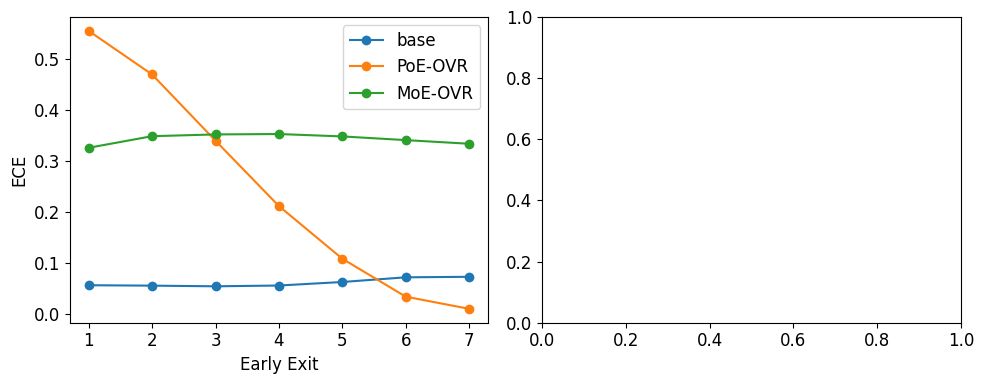

In [42]:
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for _probs, label in zip([probs, probs_poe_ovr_break_ties, probs_moe_ovr_break_ties], ['base', 'PoE-OVR', 'MoE-OVR']):
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(list(range(1, L + 1)), ece, marker='o', label=label)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('ECE')
ax[0].legend()

plt.tight_layout()
# plt.savefig(f'figures/figure_4.pdf', dpi=1200)
plt.show()

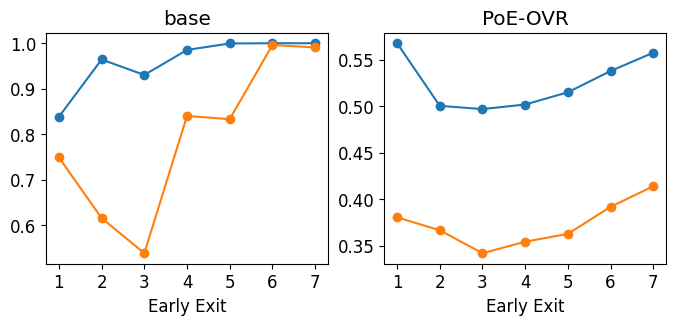

In [43]:
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
early_exits = [i + 1 for i in range(L)]

ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[0].set_xticks(early_exits)
ax[0].set_title('base')


ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        # probs_i = probs_poe_ovr_break_ties[:, i, preds_poe_ovr_break_ties[L - 1][i]].cpu()
        probs_i = probs_moe_ovr_break_ties[:, i, preds_moe_ovr_break_ties[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)
ax[1].set_title('PoE-OVR')

# plt.savefig(f'figures/figure_3_{PLOT_TYPE}.pdf', dpi=1200)
plt.show()